# Demostration of NLP Methods for Reddit Posts




## Table of Contents <a name=toc /></a>

* [inputs](#inputs)
    * relevant_search_terms_categories
* [search_posts](#search_posts)
* [enrichment](#enrichment)
    * [Relevance to `topic`](#relevance)
        * [topic_relation_cutoff](#topic_relation_cutoff)
    * [zero_shot_classification](#zero_shot_classification)
    * [image_to_text](#image_to_text)
    * [visual-question-answering](#visual-question-answering)
    * [zero-shot-image-classification](#zero-shot-image-classification)
    * [ner](#ner)

In [1]:
# common python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
# python libraries
import os
from IPython.display import clear_output
import datetime as dt
import time


In [2]:
# Reddit access
import praw
import pickle
from reddit_api import Reddit_API
api_keys = pickle.load(open('./monkey.pkl','rb'))
praw_reddit = praw.Reddit(client_id=api_keys['personal use script'],
                     client_secret=api_keys['Token'],
                     user_agent= api_keys['app name'],
                     username=api_keys['username'],
                     password= api_keys['password'])
reddit = Reddit_API()
reddit.connect_reddit(pickle_name = 'monkey')

<Response [200]>


In [3]:
# nlp libraries

# hugging face
import transformers
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer

# custom ChatGPT, VADER, Spacy library
import content_evaluator as ce
evaluator = ce.Content_Evaluator()

API key loaded from api_key.pkl


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Notebook functions
def plot_col(df, col):
    df = df.sort_values('created')
    plt.figure(figsize=(10, 6))
    plt.plot(df['created'], df[col])
    plt.xlabel('Created')
    plt.ylabel(col)
    plt.title(f'{col} vs Created')
    plt.show()

## Inputs

In [5]:
topic = 'alcoholic beverages'

pull_fresh_data = False

In [6]:
folder_name = topic.replace(' ','_')
folder_path = './data/'+folder_name+'/'
try:
    os.listdir(folder_path)
except:
    os.mkdir(folder_path)

### relevant_search_terms_categories

In [7]:
# todo: LLMs like openai can provide the search terms as was done here. This should be automated
search_terms = ["alcohol","drinks","cocktails","beer","wine","liquor","spirits",
    "happyhour","mixology","bartender","craftbeer","winelover","drinkstagram",
    "whiskey","vodka","gin","rum","tequila","drinking","drinkresponsibly"]

categories = ['Cocktail recipes and tutorials','Wine and beer recommendations','Party and event photos','Alcohol-related memes and humor',
              'Reviews of bars and restaurants','Alcohol-related news and trends','Personal stories and experiences','Celebrity endorsements and sponsorships',
              'Health and wellness tips','Advocacy and activism']

## search_posts <a name='search_posts' /></a>

[table_of_contents](#toc)

In [8]:
fname = 'raw_reddit_posts.csv'
if pull_fresh_data:
    raw_reddit_posts = pd.DataFrame()
    for search_term in search_terms:
        print(f'searching {search_term}...')
        df = reddit.post_search(search_term, limit = 1000)
        df['search_term'] = search_term
        raw_reddit_posts = pd.concat([results_df, df])
        raw_reddit_posts = raw_reddit_posts[~raw_reddit_posts.duplicated()].reset_index(drop = True)
    raw_reddit_posts['created'] = pd.to_datetime(raw_reddit_posts['created_utc'], unit='s', utc=True)
    # Convert the UTC timestamps to local time
    local_timezone = 'America/Chicago'  # Replace with the desired timezone
    raw_reddit_posts['created'] = raw_reddit_posts['created'].dt.tz_convert(local_timezone)#.dt.strftime('%Y_%b_%d %H_%M')
    clear_output(wait = True)
    raw_reddit_posts.to_csv(folder_path+fname)
else:
    raw_reddit_posts = pd.read_csv(folder_path+fname, index_col = 0)
print(raw_reddit_posts.shape)
raw_reddit_posts.head()

(4206, 15)


,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,num_comments,url,upvote_ratio,ups,search_term
0,2023-04-26 08:37:09-05:00,1.682516e+09,therewasanattempt,t5_39ne7,NaN,t2_hjvdrg5v,to underestimate alcohol,t3_12zhtwt,12zhtwt,HornyDiggler,3471,https://v.redd.it/43hzn0d1f8wa1,0.81,56008,alcohol
1,2023-03-01 16:42:49-06:00,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,544,https://www.reddit.com/r/unpopularopinion/comm...,0.89,2201,alcohol
2,2023-01-31 17:27:18-06:00,1.675208e+09,AskReddit,t5_2qh1i,NaN,t2_2wguso99,"Redditors, why don't you drink alcohol or why ...",t3_10qdyyd,10qdyyd,LuGGooo,2524,https://www.reddit.com/r/AskReddit/comments/10...,0.84,797,alcohol
3,2023-03-02 15:30:39-06:00,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,284,https://www.reddit.com/r/loseit/comments/11geo...,0.96,2512,alcohol
4,2023-04-13 02:12:06-05:00,1.681370e+09,kratom,t5_2qx0h,Anyone else like this combo? Kratom alone is p...,t2_9rxdm8ll,Alcohol and kratom,t3_12kfpoq,12kfpoq,slideguitarking,103,https://www.reddit.com/r/kratom/comments/12kfp...,0.78,20,alcohol


## enrichment <a name='enrichment' /></a>

[table_of_contents](#toc)


### Relevance to `topic` <a name='relevance' /></a>

[table_of_contents](#toc)

In [9]:
%%time
fname = 'enhanced_reddit_posts.csv'
candidate_labels = [f'Related to {topic}', f'Not Related to {topic}']

if pull_fresh_data:
    
    classifier = pipeline("zero-shot-classification")
    
    exceptions = []
    start_time = time.time()
    
    #enhanced_reddit_posts = raw_reddit_posts.copy()
    
    for i, row in enhanced_reddit_posts.iterrows():
        try:
            results = classifier(row['title'], candidate_labels)
        except Exception as e:
            print(e)
            exceptions.append(e)
        results = dict(zip(results['labels'],results['scores']))
        for label, score in results.items():
            enhanced_reddit_posts.loc[i, label] = score

        wall_time = time.time() - start_time
        average_time = wall_time/(i+1)
        clear_output(wait=True)
        print(f'''
        wall_time: {wall_time}
        average_time: {average_time}
        finished {i+1} out of {len(enhanced_reddit_posts)}
        ''')
    enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])
    enhanced_reddit_posts.to_csv(folder_path+fname)
    
else:
    enhanced_reddit_posts = pd.read_csv(folder_path+fname, index_col = 0)
    enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])

print(enhanced_reddit_posts.shape)
enhanced_reddit_posts[['created','subreddit','selftext','title'] + candidate_labels].head()

(3769, 32)
CPU times: user 464 ms, sys: 15.4 ms, total: 480 ms
Wall time: 481 ms


,created,subreddit,selftext,title,Related to alcoholic beverages,Not Related to alcoholic beverages
0,2011-09-12 10:22:23-05:00,washingtondc,NaN,"Tuesday, September 13 - Hacker News Meetup Hap...",0.836798,0.163202
1,2011-12-27 07:48:34-06:00,pittsburgh,NaN,Hey Reddit! My friend's mockumentary featuring...,0.982127,0.017873
2,2012-07-12 03:08:42-05:00,sweden,NaN,Hello winelovers!,0.996331,0.003669
3,2012-07-25 06:40:52-05:00,wine,"In currently staying in North of France, near ...",Winelovers! please help me pick a food wine in...,0.946011,0.053989
4,2012-11-12 22:04:59-06:00,AskReddit,I've been with this company for less than a ye...,How to overcome shyness in work parties/happyh...,0.756050,0.243950


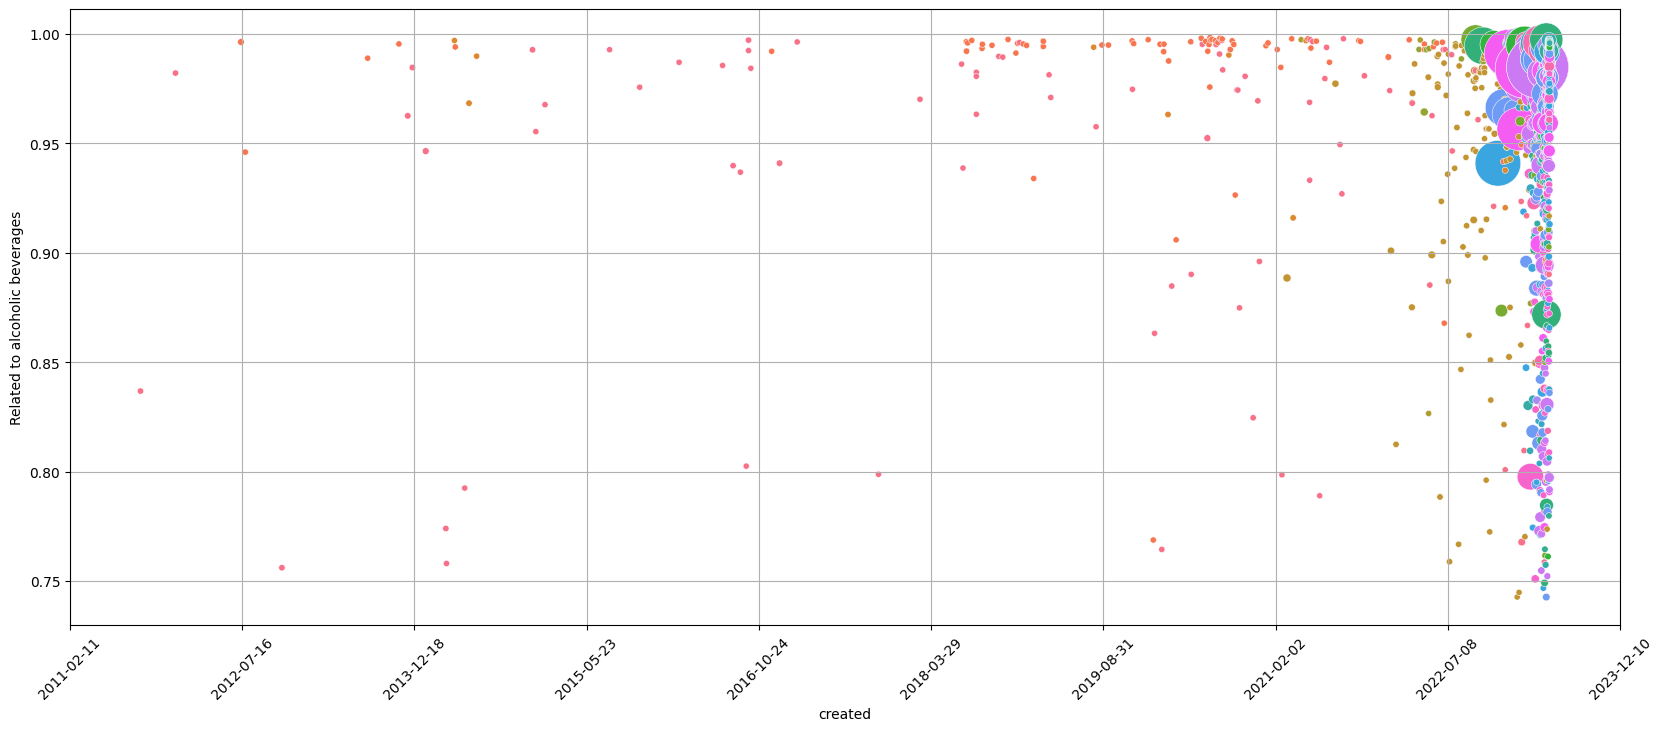

In [10]:
import matplotlib.ticker as ticker
#enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])
plt.rcParams['figure.figsize'] = [20, 8]
plot_ = sns.scatterplot(data=enhanced_reddit_posts, x='created', y=f'Related to {topic}', size="num_comments",hue = 'search_term', legend=False, sizes=(20, 2000))
plot_.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45)
plt.grid()
plt.show()

#### topic_relation_cutoff <a name = 'topic_relation_cutoff' /></a>

[table_of_contents](#toc)


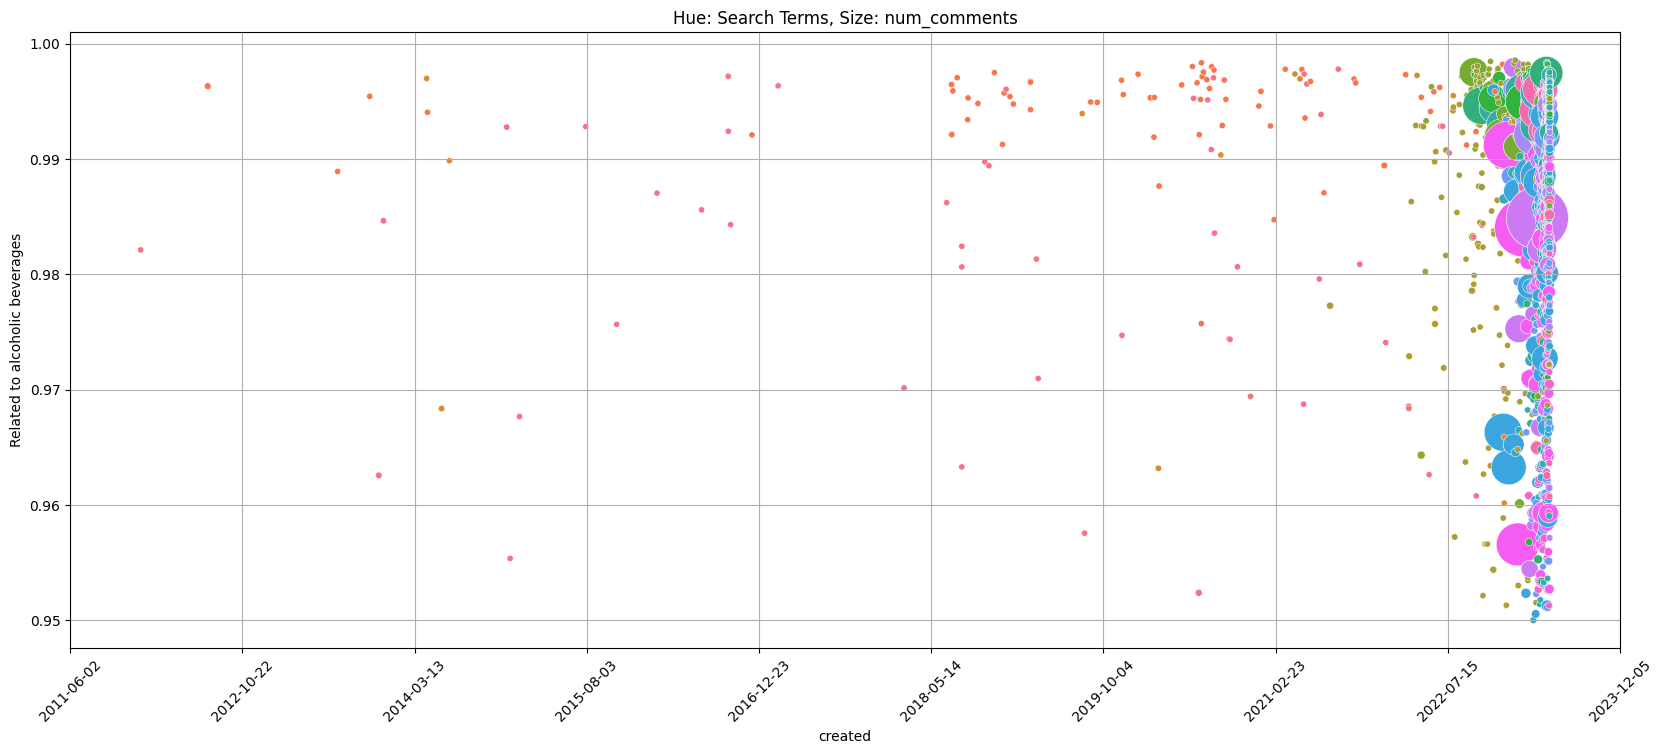

In [11]:

topic_relation_cutoff = 0.95
topic_relation_mask = enhanced_reddit_posts[f'Related to {topic}'] >= topic_relation_cutoff

plt.rcParams['figure.figsize'] = [20, 8]
plot_ = sns.scatterplot(data=enhanced_reddit_posts[topic_relation_mask], x='created', y=f'Related to {topic}', size="num_comments",hue = 'search_term', legend=False, sizes=(20, 2000))
plot_.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45)
plt.grid()
plt.title('Hue: Search Terms, Size: num_comments')
plt.show()

### zero-shot-classification <a name='zero_shot_classification' /></a>

* categorizes the title only

[table_of_contents](#toc)

##### demo

In [17]:
classifier = pipeline("zero-shot-classification")
text = 'I love drinking tequilia'
candidate_labels = ['Related to alcoholic beverages', 'Not related to alcoholic beverages']
classifier(text, candidate_labels)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'I love drinking tequilia',
 'labels': ['Related to alcoholic beverages',
  'Not related to alcoholic beverages'],
 'scores': [0.9949869513511658, 0.005013044457882643]}

In [12]:
print(categories)

['Cocktail recipes and tutorials', 'Wine and beer recommendations', 'Party and event photos', 'Alcohol-related memes and humor', 'Reviews of bars and restaurants', 'Alcohol-related news and trends', 'Personal stories and experiences', 'Celebrity endorsements and sponsorships', 'Health and wellness tips', 'Advocacy and activism']


In [13]:
%%time
fname = 'enhanced_reddit_posts.csv'
if pull_fresh_data:

    classifier = pipeline("zero-shot-classification")
    


    candidate_labels = categories
    exceptions = []

    start_time = time.time()

    

    for i, row in enhanced_reddit_posts.iterrows():
        try:
            results = classifier(row['title'], candidate_labels)
        except Exception as e:
            print(e)
            exceptions.append(e)
        results = dict(zip(results['labels'],results['scores']))
        for label, score in results.items():
            enhanced_reddit_posts.loc[i, label] = score

        wall_time = time.time() - start_time
        average_time = wall_time/(i+1)
        clear_output(wait=True)
        print(f'''
        wall_time: {wall_time}
        average_time: {average_time}
        finished {i+1} out of {len(enhanced_reddit_posts)}
        ''')
    enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])
    enhanced_reddit_posts.to_csv(folder_path+fname)
else:
    enhanced_reddit_posts = pd.read_csv(folder_path+fname, index_col = 0)
    enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])

print(enhanced_reddit_posts.shape)
pd.set_option('display.max_colwidth', 100) 
enhanced_reddit_posts[['created','subreddit','selftext','title','url']+categories].head()

(3769, 32)
CPU times: user 459 ms, sys: 3.68 ms, total: 462 ms
Wall time: 459 ms


,created,subreddit,selftext,title,url,Cocktail recipes and tutorials,Wine and beer recommendations,Party and event photos,Alcohol-related memes and humor,Reviews of bars and restaurants,Alcohol-related news and trends,Personal stories and experiences,Celebrity endorsements and sponsorships,Health and wellness tips,Advocacy and activism
0,2011-09-12 10:22:23-05:00,washingtondc,NaN,"Tuesday, September 13 - Hacker News Meetup Happyhour @ Vapiano’s DC, 6:00pm",http://meetup.hackernewsdc.org/events/31553492/?a=wr1_wr3&amp;eventId=31553492&amp;gj=ej26&amp;a...,0.026753,0.035920,0.270208,0.058734,0.124537,0.025968,0.133934,0.043993,0.030481,0.249471
1,2011-12-27 07:48:34-06:00,pittsburgh,NaN,Hey Reddit! My friend's mockumentary featuring the Pittsburgh HappyHour - partially filmed at Br...,http://www.youtube.com/watch?v=RUx3d6k7-X0&amp;feature=youtu.be,0.012642,0.026912,0.061144,0.640193,0.032375,0.145735,0.037306,0.010186,0.010047,0.023461
2,2012-07-12 03:08:42-05:00,sweden,NaN,Hello winelovers!,http://i.imm.io/wadQ.jpeg,0.033896,0.113876,0.034285,0.206374,0.053853,0.380068,0.104757,0.018912,0.025854,0.028125
3,2012-07-25 06:40:52-05:00,wine,"In currently staying in North of France, near the border of swiss and Germany. I'm close to the ...",Winelovers! please help me pick a food wine in France!,https://www.reddit.com/r/wine/comments/x4kpm/winelovers_please_help_me_pick_a_food_wine_in/,0.019133,0.100534,0.049769,0.266426,0.040256,0.300236,0.063441,0.042354,0.027885,0.089966
4,2012-11-12 22:04:59-06:00,AskReddit,"I've been with this company for less than a year, still new. From time to time they have happy h...",How to overcome shyness in work parties/happyhours?,https://www.reddit.com/r/AskReddit/comments/133skw/how_to_overcome_shyness_in_work_partieshappyh...,0.069093,0.049162,0.303125,0.087431,0.054021,0.127635,0.110165,0.040794,0.054631,0.103943


In [14]:
enhanced_reddit_posts = enhanced_reddit_posts.reset_index(drop = True)
for i, row in enhanced_reddit_posts.iterrows():
    enhanced_reddit_posts.loc[i, "top_category"] = row[categories][row[categories]== row[categories].max()].index[0]
    enhanced_reddit_posts.loc[i, "top_category_score"] = row[categories][row[categories]== row[categories].max()].values[0]

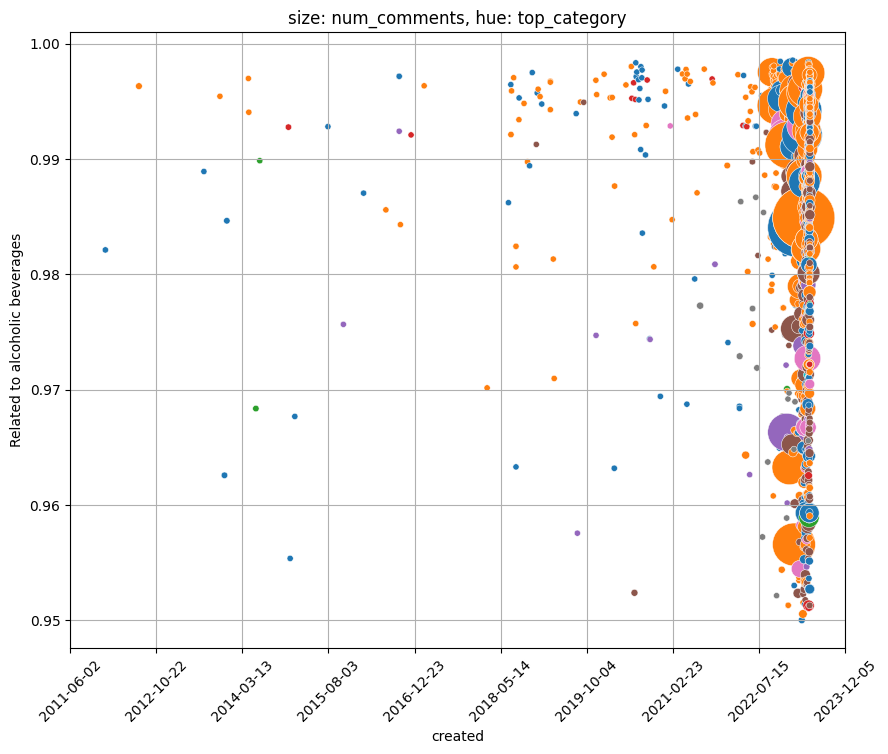

In [15]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_ = sns.scatterplot(data=enhanced_reddit_posts[topic_relation_mask], x='created', y=f'Related to {topic}', size="num_comments",hue = 'top_category', legend=False, sizes=(20, 2000))
plot_.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45)
plt.title(f"size: num_comments, hue: top_category")

plt.grid()
plt.show()

In [21]:
enhanced_reddit_posts[topic_relation_mask].subreddit.unique()

array(['pittsburgh', 'sweden', 'alcohol', ..., 'deadmau5', '2Booty',
       'ShowerBeerGoneWild'], dtype=object)

### image_to_text <a name='image_to_text' /></a>

TODO: The default model is bias towards eveything being a cellphone.  Need to look into differnt models and/or fine tune the model for this purpose

[table_of_contents](#toc)

In [18]:
image_to_text = pipeline("image-to-text")

No model was supplied, defaulted to ydshieh/vit-gpt2-coco-en and revision 65636df (https://huggingface.co/ydshieh/vit-gpt2-coco-en).
Using a pipeline without specifying a model name and revision in production is not recommended.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


##### demo

In [20]:
%%time
good_example_url = 'https://i.redd.it/3ghpmuvgyry11.jpg'
image_to_text(url)

CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 1.75 s


[{'generated_text': 'a row of wine glasses sitting on top of a counter '}]

In [21]:
%%time
bad_example_url = 'https://i.redd.it/kiy0algy5x721.jpg'
image_to_text(bad_example_url)

CPU times: user 3.01 s, sys: 13 ms, total: 3.02 s
Wall time: 1.62 s


[{'generated_text': 'a note with a knife and a bag of seeds '}]

In [55]:
%%time
#(enhanced_reddit_posts[topic_relation_mask].url.str.contains('.jpeg')) |
image_mask = ( 
             (enhanced_reddit_posts[topic_relation_mask].url.str.contains('.png'))|
             (enhanced_reddit_posts[topic_relation_mask].url.str.contains('.jpg')))
k = 0
for i, row in enhanced_reddit_posts[topic_relation_mask & image_mask ].iterrows():
    
    image_to_text_output = image_to_text(row['url'])[0]['generated_text']
    enhanced_reddit_posts.loc[i,'image_to_text_output']  = image_to_text_output
    k+=1
    clear_output(wait= True)
    print(f'''
    results {k} of {len(enhanced_reddit_posts[topic_relation_mask & image_mask ])}
    url: {row['url']}
    image_to_text_output: {image_to_text_output}
    
    ''')

    
    


    results 1178 of 1178
    url: https://i.redd.it/hodfq9oxdbza1.jpg
    image_to_text_output: a woman is sitting on the toilet with a bottle of water 
    
    
CPU times: user 1h 1min 57s, sys: 8.36 s, total: 1h 2min 5s
Wall time: 33min 28s


In [62]:
cols = ['image_to_text_output','title','url','subreddit']
enhanced_reddit_posts[~enhanced_reddit_posts['image_to_text_output'].isna()][cols]

,image_to_text_output,title,url,subreddit
49,a little boy holding a cell phone,#happyhour,https://i.redd.it/s7pudp0dj8t11.jpg,u_cjmcguin
51,a row of wine glasses sitting on top of a coun...,"It’s Friday ... that means wine night, right?!...",https://i.redd.it/3ghpmuvgyry11.jpg,u_NixonandCompany
53,"a sign that says ""no parking""",I think YES! #saturday #saturdaynight #saturda...,https://i.redd.it/jesjjhp9ij421.jpg,u_NixonandCompany
55,a note with a knife and a bag of seeds,Life lesson: when in doubt ... go for both. #w...,https://i.redd.it/kiy0algy5x721.jpg,u_NixonandCompany
56,"a sign that says ""the best place to read""",Happy Friday! 🍷 #winedown #winenight #winelove...,https://i.redd.it/odn0zwpshw921.jpg,u_NixonandCompany
...,...,...,...,...
3757,a painting of a man and a cow,What's in This Wine?!? (FanOfThefurr),https://i.imgur.com/rO4G4hF.jpg,gfur
3762,a book with a picture of a cat on it,Just got my Coco Vodka x Deadmau5 package 🍸,https://i.redd.it/ehg7vqy7iaza1.png,deadmau5
3763,a bottle of alcohol sitting on top of a wooden...,Made my first whiskey sour last night and want...,https://i.redd.it/hodr6r4wjaza1.jpg,cocktails
3765,a bottle of water is sitting on a shelf,Does anyone know this gin?,https://i.redd.it/7h7up4nvoaza1.jpg,Gin


### visual-question-answering <a name='visual-question-answering'/></a>

[table_of_contents](#toc)

In [23]:
visual_questions = pipeline("visual-question-answering")

No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision 4355f59 (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


##### demo

Additional training will need to be performed

In [26]:
good_example_url = 'https://i.redd.it/3ghpmuvgyry11.jpg'
question = 'Is there wine in this picture?'

visual_questions(image = good_example_url, question = question)

[{'score': 0.9992218017578125, 'answer': 'yes'},
 {'score': 0.020529255270957947, 'answer': 'no'},
 {'score': 0.013729427009820938, 'answer': 'red'},
 {'score': 0.0016652301419526339, 'answer': 'wine'},
 {'score': 0.0008065238362178206, 'answer': 'y'}]

In [30]:
good_example_url = 'https://i.redd.it/3ghpmuvgyry11.jpg'
question = 'Is there whiskey in this picture?'

visual_questions(image = good_example_url, question = question)

[{'score': 0.9957455992698669, 'answer': 'yes'},
 {'score': 0.12070357799530029, 'answer': 'no'},
 {'score': 0.0007335823029279709, 'answer': 'y'},
 {'score': 0.0003795808006543666, 'answer': '1'},
 {'score': 0.0003291090833954513, 'answer': 'wine'}]

In [27]:
question = 'Is there 1 or more alcoholic beverages in this picture?'

visual_questions(image = good_example_url, question = question)

[{'score': 0.297445684671402, 'answer': 'yes'},
 {'score': 0.21621951460838318, 'answer': '1'},
 {'score': 0.180906280875206, 'answer': '2'},
 {'score': 0.09829951822757721, 'answer': 'no'},
 {'score': 0.07762617617845535, 'answer': '4'}]

In [28]:
question = 'How many alcoholic beverages are in this picture?'

visual_questions(image = good_example_url, question = question)

[{'score': 0.3536076545715332, 'answer': '6'},
 {'score': 0.3037484586238861, 'answer': '5'},
 {'score': 0.24146808683872223, 'answer': '7'},
 {'score': 0.181230366230011, 'answer': '8'},
 {'score': 0.15175552666187286, 'answer': '9'}]

### zero-shot-image-classification <a name=zero-shot-image-classification /></a>

[table_of_contents](#toc)

In [31]:
image_classifier = pipeline("zero-shot-image-classification")

No model was supplied, defaulted to openai/clip-vit-base-patch32 and revision f4881ba (https://huggingface.co/openai/clip-vit-base-patch32).
Using a pipeline without specifying a model name and revision in production is not recommended.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [37]:
good_example_url = 'https://i.redd.it/3ghpmuvgyry11.jpg'
candidate_labels = ['Related to alcoholic beverages', 'Not related to alcoholic beverages']
image_classifier(good_example_url,candidate_labels = candidate_labels)

[{'score': 0.767162561416626, 'label': 'Related to alcoholic beverages'},
 {'score': 0.2328374981880188, 'label': 'Not related to alcoholic beverages'}]

### NER <a name='ner' /></a>

[table_of_contents](#toc)

In [ ]:
ner = pipeline("token-classification")

#### TO DO:
* kmeans over the text.  How well does it perform against BERT?
    * if it performs well enough it could be used as a first pass filter.

In [64]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X)
X = enhanced_reddit_posts[categories].to_numpy()
X = X.astype(float)

In [ ]:
axes, fig = plt.subplots(ncols = 5, nrows=2)
axes = axes.fatten()
for i, ax in enumerate(axes):
    print(ax)
    

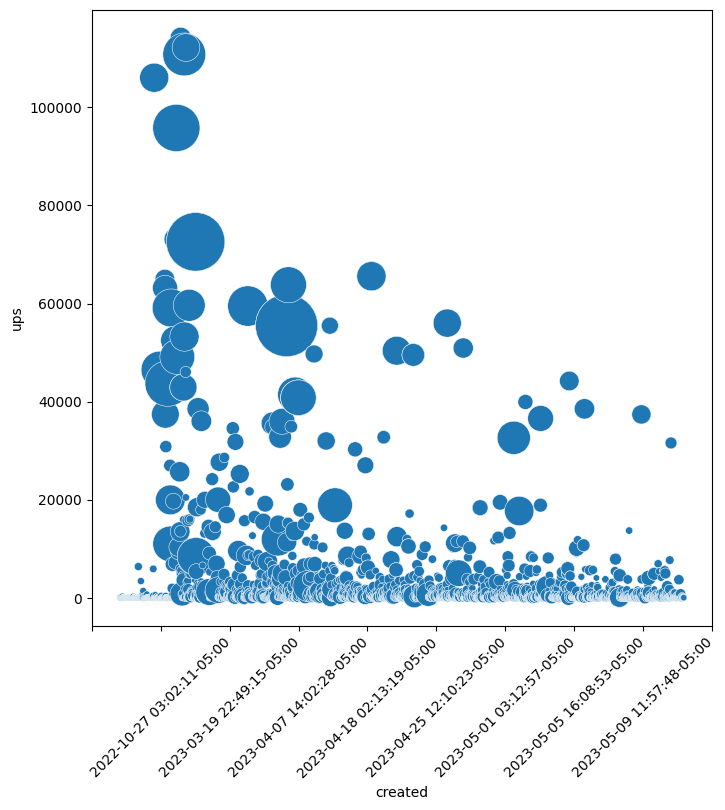

In [94]:
category = categories[0]
df = enhanced_reddit_posts[['created','ups','num_comments']+[category]]
plot_ = sns.scatterplot(data=df, x='created', y="ups", size="num_comments", legend=False, sizes=(20, 2000))
plot_.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45)
plt.show()

In [95]:
categories[0]

'Cocktail recipes and tutorials'

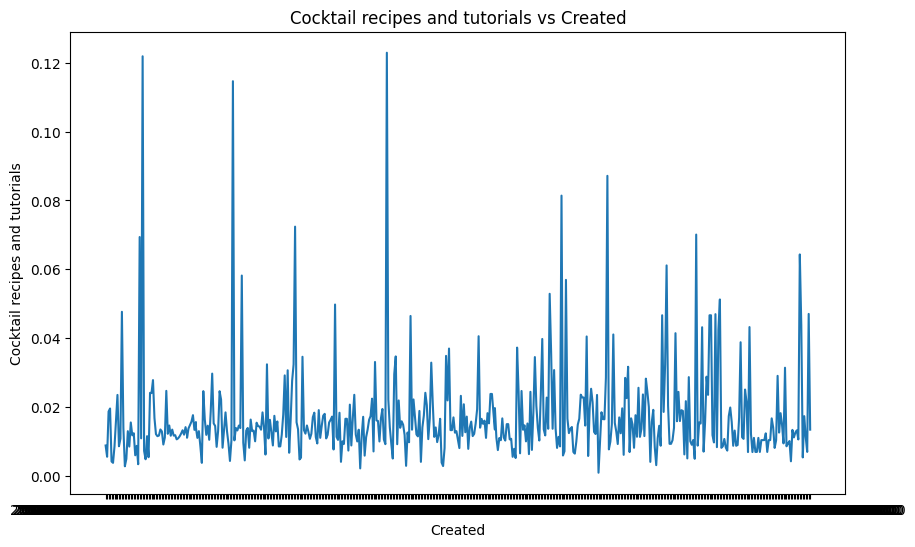

In [76]:
enhanced_reddit_posts[kmeans==2],categories[0]

### sentimentalizer 

In [86]:
%%time
for i, row in enhanced_reddit_posts.iterrows():
    # evaluate the title
    enhanced_reddit_posts.loc[i, 'title_vader_sentiment'] = evaluator.vader_sentiment(row.title)
    # evaluate the text
    if not pd.isna(row.selftext):
        enhanced_reddit_posts.loc[i, 'selftext_vader_sentiment'] = evaluator.vader_sentiment(row.selftext)

CPU times: user 4.03 s, sys: 32 ms, total: 4.06 s
Wall time: 4.05 s


In [100]:
enhanced_reddit_posts['overall_sentiment'] = (enhanced_reddit_posts['title_vader_sentiment'] + enhanced_reddit_posts['selftext_vader_sentiment'].fillna(enhanced_reddit_posts['title_vader_sentiment']))/2

### NER

In [111]:
i = 6
print(enhanced_reddit_posts.loc[i,'title'])
evaluator.named_entity(enhanced_reddit_posts.loc[i,'title'])

DWCC (EWBC) the Rioja chronicles: Dressed for sucess. Lots of photos of winelovers &amp; some thoughts of the conference and Rioja wines.


{'ORG': 'EWBC', 'PERSON': 'Rioja'}

### custom questions

In [119]:
%%time
model_name = "deepset/roberta-base-squad2"
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

questions = {'alcoholic_beverages': 'What alcoholic beverages are in the following text? ',
            }
for i, row in enhanced_reddit_posts.iterrows():
    
    for col, question in questions.items():
        if not pd.isna(row.selftext):
            context = row['title'] + " - " + row['selftext']
        else:
            context = row['title']
        QA_input = {
            'question': question,
            'context': f'text: {context}'
        }
        res = nlp(QA_input)
        enhanced_reddit_posts.loc[i,col] = res['answer']
        enhanced_reddit_posts.loc[i,col+ '_score'] = res['score']
        print(f'''
        answer:  {res['answer']}
        score: {res['score']}
        iteration {i} of {len(enhanced_reddit_posts)}
        ''')
        clear_output(wait=True)



CPU times: user 38min 59s, sys: 7.32 s, total: 39min 6s
Wall time: 19min 33s


In [126]:
enhanced_reddit_posts[['alcoholic_beverages','alcoholic_beverages_score']].sort_values('alcoholic_beverages_score',ascending = False).head(30)

,alcoholic_beverages,alcoholic_beverages_score
607,"White Claw, Truly, whiskey",0.916314
2492,"whiskey, rum, vodka",0.894980
2491,"whiskey, rum, vodka",0.894980
1325,energy drinks,0.841902
2839,spirits,0.841236
526,Razorback Red Rum and Ale,0.808995
3295,Tequila,0.806059
3583,Sobe Drinks,0.801776
3596,Mince beef pie mash and liquor,0.795808
3181,vodka,0.789780


In [129]:
enhanced_reddit_posts.to_csv(folder_path+'enhanced_reddit_posts.csv')

In [76]:
#enhanced_reddit_posts = pd.read_csv(folder_path+'enhanced_reddit_posts.csv',index_col = 0)
enhanced_reddit_posts = enhanced_reddit_posts[enhanced_reddit_posts[f'Related to {topic}'] > one_sigma]
enhanced_reddit_posts['created'] = pd.to_datetime(enhanced_reddit_posts['created'])
enhanced_reddit_posts = enhanced_reddit_posts.sort_values('created')
enhanced_reddit_posts = enhanced_reddit_posts.reset_index(drop = True)

## Seed Analysis

* ideas
    * cluster analysis
    * case study:
        * compare budlight's stock price to related trending topics
    * cluster posters

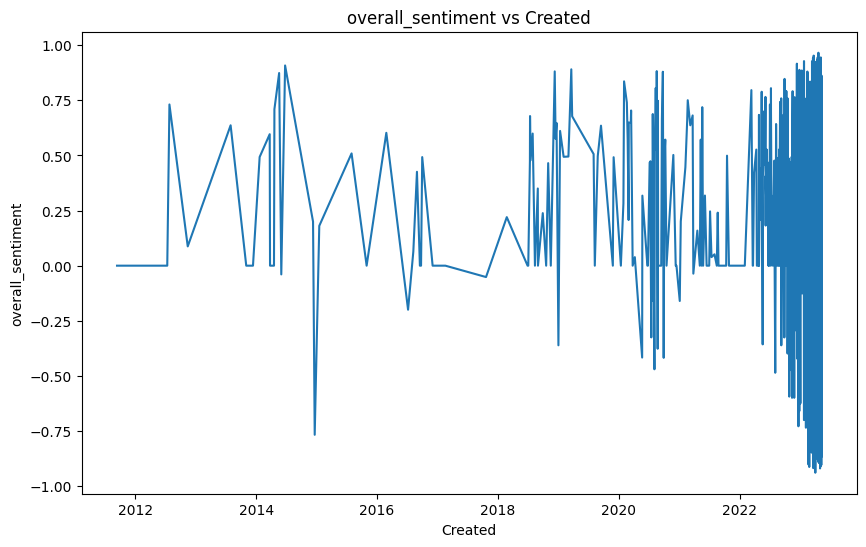

In [102]:
def plot_col(df, col):
    df = df.sort_values('created')
    plt.figure(figsize=(10, 6))
    plt.plot(df['created'], df[col])
    plt.xlabel('Created')
    plt.ylabel(col)
    plt.title(f'{col} vs Created')
    plt.show()
plot_col(enhanced_reddit_posts,'overall_sentiment')

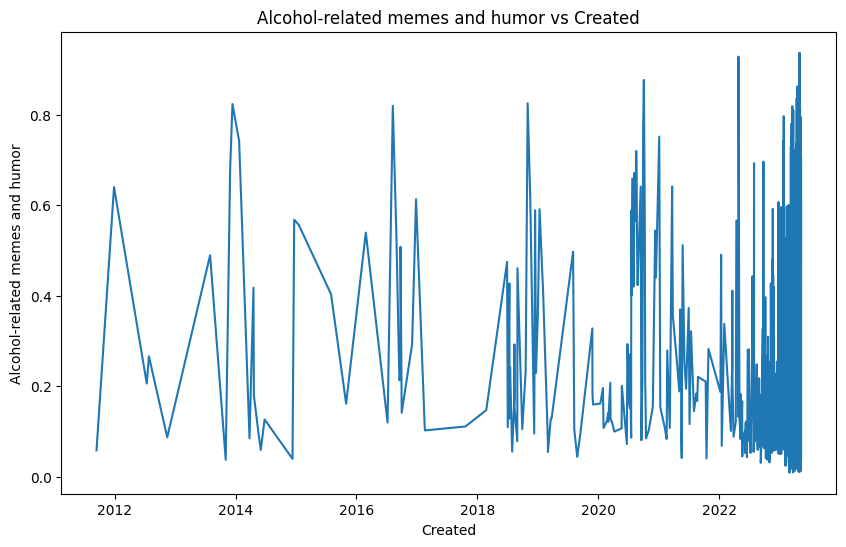

In [69]:
df = enhanced_reddit_posts.copy()
def plot_col(df, col):
    df['created'] = pd.to_datetime(df['created'])
    df = df.sort_values('created')
    plt.figure(figsize=(10, 6))
    plt.plot(df['created'], df[col])
    plt.xlabel('Created')
    plt.ylabel(col)
    plt.title(f'{col} vs Created')
    plt.show()

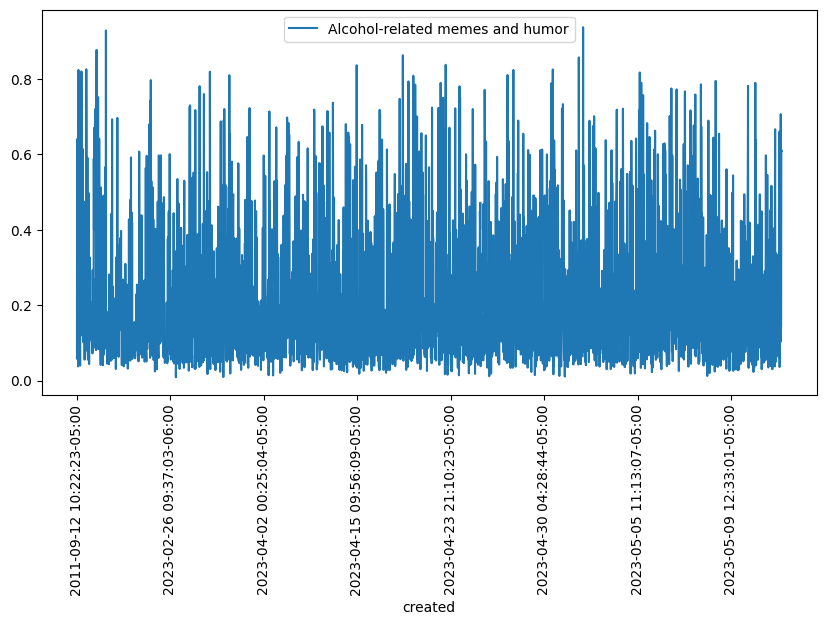

In [61]:
sub_topic = 'Alcohol-related memes and humor'

enhanced_reddit_posts[['created',sub_topic]].plot(x = 'created', y = sub_topic, figsize = (10,5))
plt.xticks(rotation=90)
plt.show()

#### top subreddits for each category

In [46]:
# average category relevance for each subreddit
subreddit_catagories = pd.DataFrame()
for subreddit, frame in enhanced_reddit_posts.groupby('subreddit'):
    for cat in categories:
        subreddit_catagories.loc[subreddit, cat] = sum(frame[cat])/len(frame)
        
subreddit_catagories = subreddit_catagories.reset_index().rename(columns = {'index':'subreddit'})
print(subreddit_catagories.shape)
subreddit_catagories.head() 
       

,subreddit,Cocktail recipes and tutorials,Wine and beer recommendations,Party and event photos,Alcohol-related memes and humor,Reviews of bars and restaurants,Alcohol-related news and trends,Personal stories and experiences,Celebrity endorsements and sponsorships,Health and wellness tips,Advocacy and activism
0,196,0.110019,0.086267,0.069119,0.158448,0.105729,0.333213,0.043904,0.035483,0.027569,0.030249
1,2007scape,0.020478,0.019449,0.037781,0.095426,0.047768,0.202408,0.424670,0.021695,0.056921,0.073405
2,2Booty,0.019722,0.007200,0.026556,0.706549,0.014132,0.155797,0.032734,0.014085,0.009853,0.013373
3,2busty2hide,0.079524,0.081232,0.057058,0.132917,0.056389,0.429006,0.106779,0.020011,0.017887,0.019196
4,2hujerk,0.015248,0.105928,0.016048,0.055244,0.020961,0.739628,0.026358,0.004445,0.006775,0.009364


In [47]:
subreddit_catagories.shape

(1596, 11)

In [17]:
# for each category what are the top subreddits
category_top_subreddits = {}
for cat in categories:
    list(subreddit_catagories[subreddit_catagories[cat]>0.5].subreddit)
    category_top_subreddits[cat] = 

In [25]:
enhanced_reddit_posts[enhanced_reddit_posts['subreddit']=='Detroit'].url

1388    https://i.redd.it/ccztru01obra1.jpg
Name: url, dtype: object

In [27]:
i = 3
print(categories[i])
category_top_subreddits[categories[i]]

Alcohol-related memes and humor


['2Booty',
 '3Dprinting',
 '52weeksofcooking',
 '90DayFiance',
 'AR10',
 'BBW',
 'Blacksmith',
 'Blacktittyworld',
 'BollyBlindsNGossip',
 'Bowyer',
 'BungouSimpBattles',
 'Burlesque',
 'ChallengeAccepted',
 'ComedyNecrophilia',
 'CraftBeerBoobs',
 'Destiny',
 'DeutscheNSFW',
 'Drunkknitting',
 'FireEmblemWaifus',
 'ForwardsFromKlandma',
 'FunnyAnimals',
 'GROOLGW',
 'GermansGoneWild',
 'GoneWildAudioGay',
 'GoodAssSub',
 'Grapplerbaki',
 'HadesTheGame',
 'HumansAreMetal',
 'IShouldBuyABoat',
 'ImagesOfRussia',
 'JohnMulaney',
 'JohnWick',
 'Lackadaisy',
 'MadeOfStyrofoam',
 'Maplestory',
 'Milfie',
 'MisogynisticLife',
 'MySingingMonsters',
 'NRWGay',
 'Ni_Bondha',
 'OUTFITS',
 'OnlyAdultContent',
 'Overwatch_Porn',
 'PUBLICNUDITY',
 'PeakyBlinders',
 'PetAfterVet',
 'Pizza',
 'PokePorn',
 'Pokemongiveaway',
 'PowerMetal',
 'PrequelMemes',
 'RedheadBeauties',
 'SFMCompileClub',
 'SaimanSays',
 'SeattleKraken',
 'ShowerBeerGoneWild',
 'StableDiffusion',
 'StupidFood',
 'TaylorSwift',
 

In [23]:
subreddit_catagories.sort_values('Cocktail recipes and tutorials',ascending=False)

,Cocktail recipes and tutorials,Wine and beer recommendations,Party and event photos,Alcohol-related memes and humor,Reviews of bars and restaurants,Alcohol-related news and trends,Personal stories and experiences,Celebrity endorsements and sponsorships,Health and wellness tips,Advocacy and activism
u_businessnewstv,0.826646,0.007961,0.009714,0.014950,0.006064,0.092191,0.021274,0.007479,0.005640,0.008080
hogwartslegacyJKR,0.775837,0.011746,0.011467,0.012015,0.005328,0.134568,0.017131,0.007003,0.013247,0.011658
knolling,0.743977,0.054834,0.018372,0.043787,0.012289,0.055171,0.040284,0.012588,0.010663,0.008035
u_localhero247,0.715964,0.021820,0.021525,0.026720,0.019261,0.108258,0.033774,0.018128,0.015419,0.019130
DarkAcademia,0.574296,0.037105,0.023947,0.032693,0.021979,0.239435,0.036693,0.010676,0.012407,0.010768
...,...,...,...,...,...,...,...,...,...,...
sbubby,0.002971,0.072200,0.004609,0.094573,0.003263,0.802793,0.006476,0.003571,0.003441,0.006105
drunklife,0.002794,0.002453,0.008821,0.417770,0.003753,0.517715,0.026478,0.002594,0.007570,0.010051
u_JimmyKim8626,0.002049,0.018115,0.004009,0.370025,0.006945,0.585350,0.007607,0.002287,0.002004,0.001609
u_Fancy_F33t,0.001635,0.056676,0.013802,0.671459,0.005455,0.228901,0.011799,0.002277,0.006748,0.001249


### analyze_categories

### Review Subreddits

In [49]:
subreddit_counts = raw_reddit_posts['subreddit'].value_counts()
description = subreddit_counts.describe()
print(f'''
Subreddit Counts
number of subreddits = {int(description['count'])}
mean subreddit count: {round(description['mean'],2)}
max subreddit count: {int(description['max'])}
min: {int(description['min'])}
25%: {int(description['25%'])}
50%: {int(description['50%'])}
75%: {int(description['75%'])}
''')



Subreddit Counts
number of subreddits = 1737
mean subreddit count: 2.42
max subreddit count: 163
min: 1
25%: 1
50%: 1
75%: 2



### Subreddits that contribute 80% of the posts

* Pareto Principle: 80% of the posts come from 20% of the subreddits

In [76]:
eighty_percent = int(round(raw_reddit_posts.shape[0] * .8,0)) 
eight_percent_subreddits = {}
count = 0
for subreddit,v in subreddit_counts.items():
    if count > eighty_percent: break
    eight_percent_subreddits[subreddit] = v
    count +=v
num_of_80 = len(eight_percent_subreddits.keys())
percent_of_total = 100*round(num_of_80/raw_reddit_posts.shape[0],1)
print(f'''
number of subreddits that contribute to 80% of posts: {num_of_80}
percent that the eighty_percent contribute: {percent_of_total}%
''')
    


number of subreddits that contribute to 80% of posts: 897
percent that the eight_percent contribute: 20.0%



In [77]:
eight_percent_subreddits

{'BreweryJobsdotcom': 163,
 'stopdrinking': 114,
 'cocktails': 112,
 'bartenders': 83,
 'rum': 75,
 'AskOuija': 58,
 'tequila': 53,
 'whiskey': 52,
 'Gin': 39,
 'Mixology': 36,
 'wine': 33,
 'HentaiAndRoleplayy': 32,
 'u_Less-Morning-8163': 31,
 'todayilearned': 30,
 'bourbon': 27,
 'Tiki': 26,
 'mildlyinteresting': 25,
 'BlueArchive': 22,
 'drunk': 21,
 'Weddingattireapproval': 20,
 'facepalm': 20,
 'PublicFreakout': 20,
 'vanderpumprules': 17,
 'Damnthatsinteresting': 16,
 'interestingasfuck': 16,
 'tapthat': 16,
 'AmItheAsshole': 16,
 'politics': 15,
 'trailerparkboys': 15,
 'alcohol': 14,
 'science': 14,
 'CasualUK': 14,
 'Yogscast': 14,
 'bleach': 14,
 'u_SFF_Georgia': 14,
 'firewater': 14,
 'NoStupidQuestions': 13,
 'CraftBeer': 12,
 'nottheonion': 12,
 'community': 12,
 'baseball': 12,
 'AskReddit': 12,
 'KitchenConfidential': 11,
 'u_Ranybest': 11,
 'WIIL': 11,
 'funny': 11,
 'Conservative': 11,
 'Jokes': 11,
 'WhiskeyTribe': 11,
 'therewasanattempt': 11,
 'food': 10,
 'europe'

### Pulling the last year of posts from each of the 80% subreddits

In [154]:
subreddit = 'bartenders'
def most_recent_subreddit_posts(subreddit):
    dfs = []
    year_ago = dt.datetime.now() - dt.timedelta(days=365)
    df = reddit.sub_reddit_pull(subreddit,search = 'new',)
    df = df.sort_values('created').reset_index(drop = False)
    dfs.append(df)
    oldest_post_date =df.loc[0,'created'] 
    oldest_post_id = df.loc[0,'kind_id']
    while  oldest_post_date > year_ago:
        df = reddit.sub_reddit_pull(subreddit,search = 'new',params = {'limit': 100,'after':oldest_post_id}) 
        try:
            df = df.sort_values('created').reset_index(drop = False)
        except KeyError:
            break
        dfs.append(df)
        oldest_post_date =df.loc[0,'created'] 
        oldest_post_id = df.loc[0,'kind_id']
    df = pd.concat(dfs)
    return df


In [ ]:
dfs = []
for i, (subreddit, _) in enumerate(eight_percent_subreddits.items()):
    if subreddit in seen_subs:
        continue
    print(f'''
    processing {subreddit}
    iteration: {i}''')
    df = most_recent_subreddit_posts(subreddit)
    df['subreddit'] = subreddit
    dfs.append(df)
raw_recent_posts = pd.concat(dfs)
print(raw_recent_posts.shape)
raw_recent_posts.head()

In [ ]:
print(raw_recent_posts.shape)
raw_recent_posts.head()

In [146]:
len(dfs)

252

In [156]:
raw_recent_posts = pd.concat(dfs)

In [157]:
seen_subs = list(raw_recent_posts.subreddit.unique())

In [ ]:
seen_subs